<a href="https://colab.research.google.com/github/hideOncodee/CNN-IC2023/blob/main/IC2023_CNN_c_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação das bibliotecas

In [ ]:
import os                                   # Permite utilizar recursos so sistema operacional
import shutil                               # Manipulação de arquivos em grande escala
import zipfile                              # Manipulação de arquivos compactados
import tensorflow as tf                     # Biblioteca dedicada a aprendizado de máquina, do desenvolvimento aos testes etc.
import numpy as np                          # Manipulação facilitada de tensores (matrizes 2D E 3D neste caso)
import matplotlib.pyplot as plt             # Recursos para exibição gráfica
import cv2                                  # OpenCV - Manipulação de arquivos de imagem
import seaborn as sns                       # Recursos para exibição gráfica de dados, baseada na matplotlib
from sklearn.model_selection import KFold   # Função da biblioteca Scikit Learn para validação cruzada
from google.colab.patches import cv2_imshow # Função da biblioteca OpenCV para exibição de um arquivo de imagem

Importa e monta o acesso ao Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Organização da base de dados

In [ ]:
path = '/content/drive/MyDrive/Original.zip'            # Atribui o caminho da base de dados (compactada) à variável "path"
zip_object = zipfile.ZipFile(file = path, mode = 'r')   # Cria objeto "zip_object" contendo a base de dados (compactada)
zip_object.extractall('./')                             # Extrai (descompacta) a base da dados
zip_object.close()                                      # Fecha o objeto "zip_object", conforme sugere a documentação da bib. zipfile

**Nota**
> Carrega-se uma segunda base de dados (pacote de teste) com um padrão de captura de amostras diferente do utilizado na captura das imagens da base de dados original. Essa segunda base de dados é muito menor, e é incorporada a base original e utilizada para treinamento/validação. No entanto para *teste* é utilizada somente o **pacote de teste**, visando estudar a capacidade de generalização do modelo, conforme será abordado mais adiante no programa.






In [ ]:
path = '/content/drive/MyDrive/test_batch.zip'          # Atribui o caminho do pacote de teste (compactada) à variável "path"
zip_object = zipfile.ZipFile(file = path, mode = 'r')   # Cria objeto "zip_object" contendo a base de dados (compactada)
zip_object.extractall('./')                             # Extrai (descompacta) a base da dados
zip_object.close()                                      # Fecha o objeto "zip_object", conforme sugere a documentação da bib. zipfile

In [ ]:
os.makedirs('/content/Original_full')                   # Cria diretório "Original_full"

In [ ]:
splited_dirs = ['/content/Original/P13NOK', '/content/Original/P13OK', '/content/ test_batch']  # Caminhos dos diretórios que compõem a base de dados
complete_dir = '/content/Original_full'                                                         # Caminho do diretorio unificado

for dir in splited_dirs:                                                                        # Itera sob os diretorios separados
  for files in os.listdir(dir):                                                                 # Itera sob os arquivos de cada diretorio
    splited_dir_path = os.path.join(dir, files)                                                 # Atribui o caminho do arquivo do diretorio separado da iteração em questão a "splited_dir_path"
    complete_dir_path = os.path.join(complete_dir, files)                                       # Atribui o caminho do arquivo do diretorio completo da iteração em questão a "complete_dir_path

    shutil.copy(splited_dir_path, complete_dir_path)                                            # Copia o arquivo do diretorio separado para o diretorio completo, através de seus respect. caminhos

# Criar a partir da base de dados tensores de imagens e de seus respectivos rótulos

In [ ]:
files = [os.path.join(complete_dir, f) for f in sorted(os.listdir(complete_dir))]   # Cria um vetor "files" contendo todos os arquivos (caminhos) da base de dados
images = []                                                                         # Cria um vetor "images" que receberá os arquivos (caminhos) de imagem
labels = []                                                                         # Cria um vetor "labels" que receberá os rótulos (classes) de cada imagem

In [ ]:
for image_path in files:                                      # Itera sob os arquivos (caminhos) da vetor "files"
  img = cv2.imread(image_path)                                # Atribui o arquivo de imagem para "img"
  img = cv2.resize(img, (64,64))                              # Redimensiona a imagem para 64x64 pixels (H,W)

  images.append(img)                                          # Acrescenta "img" ao vetor "images"

  img_name = os.path.basename(os.path.normpath(image_path))   # Atribui o nome do arquivo de imagem da iteração à "img_name"

  if "NOK" in img_name:                                       # Verifica se a string "NOK" está contida no nome do arquivo
    label = 0                                                 # Caso sim, atritui 0 (NOK) ao rótulo do arquivo de imagem da iteração
  else:
    label = 1                                                 # Caso contrário, atribui 1 (OK)

  labels.append(label)                                        # Acrescenta "label" ao vetor "labels"

In [ ]:
# Visualização das imagens e seus respectivos labels
plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"), cmap='viridis')
    if labels[i] == 0:
      label_name = 'P13NOK'
    else:
      label_name = 'P13OK'
    plt.title(label_name)
    plt.axis("off")

In [ ]:
X = np.asarray(images)
y = np.asarray(labels)

print(X.shape, y.shape)

(1238, 64, 64, 3) (1238,)


# Normalização dos dados

Altera a escala dos pixels de 0 - 255 para 0 - 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_og_shape = X.shape
X = X.reshape((-1, X.shape[-1]))

print(X.shape, X_og_shape)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = X.reshape(X_og_shape)

print(X[100].max(), X[100].min(), X.shape)

# Divisão das bases de treinamento e teste

In [ ]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X.shape, X_test.shape, y.shape, y_test.shape)

(990, 64, 64, 3) (248, 64, 64, 3) (990,) (248,)


# Camada de Data Augmentation


*   RandomFlip()
*   RandomRotation()



In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical',
                               input_shape=(64,64,3)),
    tf.keras.layers.RandomRotation(0.3),
])

In [ ]:
plt.figure(figsize=(10,10))
first_image = images[0]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

# Arquitetura da CNN



*   Input
*   Data Augmentation
*   Rescaling
*   Conv2D
*   MaxPool2D
*   Conv2D
*   MaxPool2D
*   Flatten
*   Dropout
*   BatchNormalization
*   Dense
*   Dropout
*   BatchNormalization
*   Dense


In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(64, 64, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=577, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=1, activation='sigmoid')

])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                 

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Treinamento com validação cruzada k-fold


In [ ]:
# Validação cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
  print(f"Fold {fold + 1}/{num_folds}")

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val))

  # Avalie o modelo no conjunto de validação
  results = model.evaluate(X_val, y_val)
  print(f"Fold {fold + 1} - Loss: {results[0]}, Accuracy: {results[1]}")

# Teste do modelo utilizando o dataset de teste

In [ ]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5)
# FALSE - NOK
# TRUE - OK
print(predictions)

# Performance do modelo no dataset de teste (100%)

1.0


<Axes: >

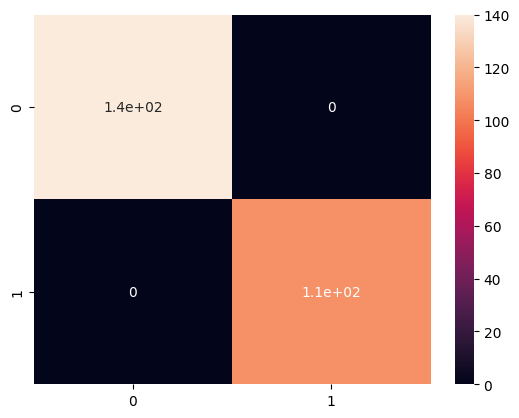

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
acc_score = accuracy_score(y_test, predictions)
print(acc_score)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True)

# Teste do modelo utilizando o dataset de amostras novas.

*   As novas amostras foram coletadas com um padrão de qualidade de captura menor, visando testar a capacidade do modelo de generalizar para novas imagens.
*   O processo de preparação do dataset de novas amostras foi idêntido ao dataset original.






In [ ]:
test_dir = '/content/test_batch'
test_images = []
test_labels = []

In [ ]:
test_files = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))]

In [ ]:
for image_path in test_files:
  img = cv2.imread(image_path)
  img = cv2.resize(img, (64,64))

  test_images.append(img)

  img_name = os.path.basename(os.path.normpath(image_path))

  if "NOK" in img_name:
    label = 0
  else:
    label = 1

  test_labels.append(label)

In [ ]:
test_X = np.asarray(test_images)
test_y = np.asarray(test_labels)

print(test_X.shape, test_y.shape)

(49, 64, 64, 3) (49,)


In [ ]:
test_predictions = model.predict(test_X)
test_predictions = (test_predictions > 0.5)
# FALSE - NOK
# TRUE - OK
print(test_predictions)

# Performance do modelo no dataset de amostras novas (75%)

0.7346938775510204


<Axes: >

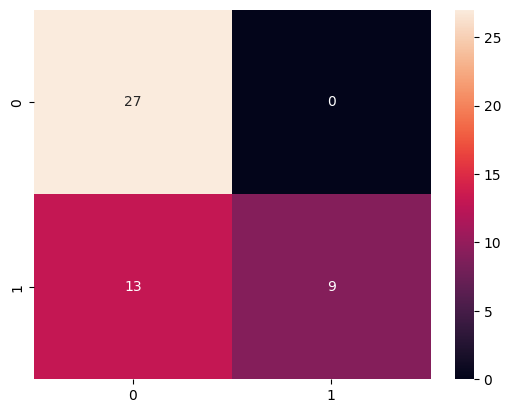

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_acc_score = accuracy_score(test_y, test_predictions)
print(test_acc_score)
test_cm = confusion_matrix(test_y, test_predictions)
sns.heatmap(test_cm, annot=True)

# Salvar os arquivos do modelo

Os arquivos são: o arquivo json que descreve a arquitetura e o arquivo hdf5 que contém os valores dos pesos treinados.

In [ ]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
model_saved = save_model(model, '/content/weights.hdf5')

<ipython-input-49-c5122d7aeb50>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  model_saved = save_model(model, '/content/weights.hdf5')
